# Incoherent noise effects

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import pickle as pkl

from LebedevHelper import *

%matplotlib notebook

In [3]:
N = int(1e6)

Qx = 0.31
Qy = 0.32
SX = np.sin(Qx*2*np.pi)
CX = np.cos(Qx*2*np.pi)
SY= np.sin(Qy*2*np.pi)
CY= np.cos(Qy*2*np.pi)

def rotation(a,b,C,S):
    temp = a
    a = C*a  + S*b
    b = -S*temp + C*b
    return a,b

def noise(NN,DD):
    return np.random.randn(NN)*DD

def noiseCoh(DD):
    return np.random.uniform(-1,1)*DD*np.sqrt(3)


D = sigk = .5/np.sqrt(3)
a = 5e-3
b = 0
g = 0.2
nbin = 300

x = np.random.randn(N)
p = np.random.randn(N)
s = np.random.randn(N)
d = np.random.randn(N)


jx0 = 0.5*(x**2+p**2)
jz0 = 0.5*(s**2+d**2)
totturns=0
jxs = [jx0]
turns=[0]

In [4]:
np.random.uniform(-1,1)

0.7494356603138104

In [8]:
newturns = int(50)
totturns+=newturns
turns+=[totturns]

method = 3
for turn in range(newturns):
    x,p = rotation(x,p,CX,SX)
    if method<=3:
        n = noise(N,D)
        if method==1:
            p1 = p + n * np.sqrt(octu_leb(abs_action(x,p),0,a,0,g))
            for i in range(2):
                p1 = p + n * np.sqrt((octu_leb(abs_action(x,p),0,a,0,g) + octu_leb(abs_action(x,p1),0,a,0,g))/2)    
            p += n * np.sqrt((octu_leb(abs_action(x,p),0,a,0,g) + octu_leb(abs_action(x,p1),0,a,0,g))/2)    
        elif method==2:
            p1 = p + n * np.sqrt(octu_leb(abs_action(x,p),0,a,0,g))
            p  = p + n * np.sqrt(octu_leb(abs_action(x,(p1+p)*.5),0,a,0,g))
        elif method==3:
            p += n * np.sqrt(octu_leb(abs_action(x,p),0,a,0,g))
    elif method==4:
        jx = 0.5*(x**2+p**2)
        dmu = func_dmu(a,jx)
        L = np.sqrt(LL(g/2,dmu))
        p += noiseCoh(D)*L
jx = 0.5*(x**2+p**2)
jz = 0.5*(s**2+d**2)
jxs += [jx]
print('Done')
print(np.array(turns)*D**2)

Done
[ 0.          4.16666667  8.33333333 12.5        16.66666667]


average growth 0.49351819271713654


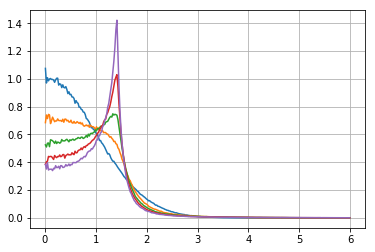

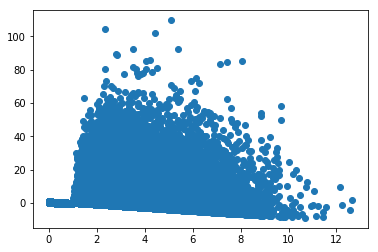

In [10]:

XS = [jx0,jz0]
YS = [jx-jx0,jx-jx0]
# XS = [np.sqrt(jx0),np.sqrt(jz0)]
# YS = [jx-jx0,jx-jx0]
if 0:
    plt.figure(figsize=(10,6))
    for j in range(2):
        ax1 = plt.subplot(121+j)
    #     H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=[[0,np.max(XS[j])],[0,np.max(YS[j])]],normed=True);
        limits = [[np.min(XS[j]),np.max(XS[j])],[np.min(YS[j]),np.max(YS[j])]]

        H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=limits,normed=True);
        H = H.transpose()

        vmax = H.max()
        vmin = np.min(H[H>0])

        X,Y = np.meshgrid(xedges, yedges);
        pcm=plt.pcolor(X,Y,H,norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
        plt.colorbar(pcm, ax=ax1, extend='max')
        plt.xlabel([r'$J_{x,0}$',r'$J_{y,0}$',r'$J_{z,0}$'][int(j/2)])
        plt.ylabel([r'$\Delta J_x$',r'$\Delta J_y$'][j%2])

        ind = np.sum(H,axis=0)>0
        avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)-np.diff(yedges)[0]*0.5
        avg2 = np.histogram(XS[j],weights=YS[j],bins = xedges)[0] / np.histogram(XS[j],bins = xedges)[0]

        plt.plot(xedges[1:][ind]-np.diff(xedges)[0]*0.5,avg,'k',lw=2)
        plt.plot(edges_to_center(xedges),avg2,'b--',lw=2)

        if j==0:
            plt.plot(xedges,octu_leb(xedges,0,a,0,g) * D**2 * totturns * 0.5)
    plt.tight_layout()

    
plt.figure()
rmax = 6
redges = np.linspace(0,rmax,nbin)
rcenters = edges_to_center(redges)
dist_rs = []
for j in jxs:
    r = np.sqrt(2*j)
    dist,_ = np.histogram(r,redges,normed=False,weights=(nbin+1)/rmax/N*np.ones(N))
    dist_r = dist/rcenters
    plt.plot(rcenters,dist_r)
    dist_rs +=[dist_r]
plt.grid(True)


plt.figure()
plt.scatter(jx0,jx-jx0)

print('average growth',np.mean(YS[0]))

# Save parameters
params = {'a':a, 'b':b, 'g':g,'D':D,'npart':N,'nbin':nbin,'rmax':rmax,'Qx':Qx,'Qy':Qy,'nt':len(turns)}
storage = {'params':params, 'rcenter':rcenters, 'dist_rs':dist_rs,'turns':turns}
dir_save = '01_Output'
dir_save = '02_Input'
with open(dir_save+'/incoherentNoise_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_Np%.0e_Nstep%d.pkl'%(
        a,b,g,D**2*totturns,N,len(turns)),'wb') as pklfile:
    pkl.dump(storage,pklfile)

In [64]:
# print(X[:,1]) # same value for x
# print(Y[:,1]) # all values for y
print(np.mean(H[:,1]))
print(H.shape,Y.shape)
ind = np.sum(H,axis=0)>0
avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)


12.9461495496
(100, 100) (101, 101)
[  3.15348361e-04   3.15511127e-04   3.30575120e-04   3.12464440e-04
   3.18655421e-04   3.31786168e-04   3.14454640e-04   3.15294549e-04
   3.07680513e-04   3.02847814e-04   2.83961838e-04   3.09505808e-04
   3.16787136e-04   3.15406569e-04   2.88757971e-04   2.98743507e-04
   3.25798257e-04   3.07821008e-04   3.39265597e-04   3.58071333e-04
   3.25016527e-04   3.88599033e-04   3.11159060e-04   3.67974202e-04
   3.38150268e-04   3.10969791e-04   3.25562341e-04   3.33433755e-04
   2.69485630e-04   3.53701044e-04   3.19154532e-04   3.43178417e-04
   1.82579889e-04   3.99371784e-04   1.91493492e-04   2.58704898e-04
   5.29929604e-04   2.93133417e-04   4.29926259e-04   2.85341665e-04
   1.86920826e-04   3.08315428e-04   2.84090731e-04   2.57988764e-04
   2.88468260e-04   4.37065326e-04   5.32295050e-04  -7.90092255e-05
   2.43432557e-04   4.29735826e-04   1.81230920e-04  -4.08706431e-04
   2.44754245e-04  -3.12459305e-05   3.33369405e-04   7.24860981e-0

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


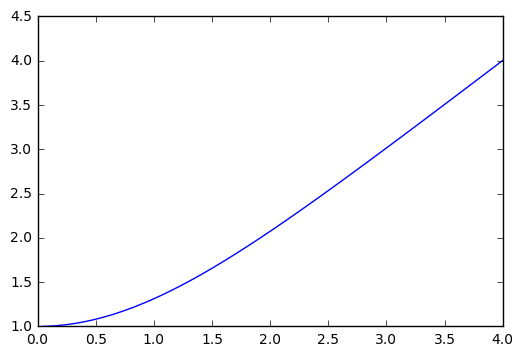

In [19]:
P = np.linspace(0,4,100)
plt.figure()
plt.plot(P,P+2*P/(np.exp(2*P)-1))